In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import csv
from tqdm.auto import tqdm
import random
from scipy.stats import pearsonr

In [19]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=1)
for para in model.parameters():
    para.requires_grad = True
'''for para in model.classifier.parameters():
    para.requires_grad = True'''

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'for para in model.classifier.parameters():\n    para.requires_grad = True'

In [21]:
file_loc = "/content/drive/MyDrive/train.csv"

In [22]:
sim_score, sentences = [], []
with open(file_loc, 'r') as f:
    train_csv = list(csv.reader(f))
    train_csv = train_csv[1:]
    for lines in train_csv:
        try:
            lines = lines[0].split("\t")
            temp_sent = lines[1]+" [SEP] "+lines[2]
            temp_score = float(lines[0])
            sentences.append(temp_sent)
            sim_score.append(temp_score)
        except:
            continue

In [23]:
print(len(sim_score), len(sentences))

4743 4743


In [24]:
file_loc_val = "/content/drive/MyDrive/dev.csv"
sim_score_val, sentences_val = [], []
with open(file_loc_val, 'r') as f:
    train_csv = list(csv.reader(f))
    train_csv = train_csv[1:]
    for lines in train_csv:
        try:
            lines = lines[0].split("\t")
            temp_score = float(lines[0])
            temp_sent = lines[1]+" [SEP] "+lines[2]
            sentences_val.append(temp_sent)
            sim_score_val.append(temp_score)
        except:
            continue

In [25]:
print(len(sim_score_val), len(sentences_val))

1083 1083


In [10]:
def train(model, epochs, loss_fxn, optimizer, train_x, train_y):
    loss_per_ep = []
    for ep in tqdm(range(epochs)):
        model.train()
        train_loss = 0
        temp = list(zip(train_x, train_y))
        random.shuffle(temp)
        train_x, train_y = zip(*temp)
        train_x, train_y = list(train_x), list(train_y)
        for X, y in zip(train_x, train_y):
            y = torch.tensor(y)
            X = tokenizer(X, return_tensors='pt')
            X, y = X.to(DEVICE), y.to(DEVICE)
            logits = model(**X).logits
            loss = loss_fxn(logits.squeeze(1)[0], y)
            train_loss += loss.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        lossperep = train_loss / len(list(train_x))
        print("For Epoch "+str(ep)+" loss = "+str(lossperep))
        loss_per_ep.append(lossperep)

        torch.save({'epoch': ep,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()}, '/content/drive/MyDrive/model_bert_new_ep_'+str(ep)+'.pth')

In [ ]:
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
train(model.to(DEVICE), 30, loss_fn, opt, sentences, sim_score)

  0%|          | 0/30 [00:00<?, ?it/s]

For Epoch 0 loss = 2.760148777878793
For Epoch 1 loss = 2.852466075613191
For Epoch 2 loss = 2.860289515950075
For Epoch 3 loss = 2.881592264136177
For Epoch 4 loss = 2.8238090368975133
For Epoch 5 loss = 2.8993282186765974
For Epoch 6 loss = 2.823421283021698
For Epoch 7 loss = 2.881420236788721
For Epoch 8 loss = 2.8364199014281337
For Epoch 9 loss = 2.9201851057532213
For Epoch 10 loss = 2.864240465474156
For Epoch 11 loss = 2.879726487814791
For Epoch 12 loss = 2.82135761348647
For Epoch 13 loss = 2.8933696200527246
For Epoch 14 loss = 2.8618396391529575
For Epoch 15 loss = 2.8297829630904943
For Epoch 16 loss = 2.848827817167166
For Epoch 17 loss = 2.8648787688583113
For Epoch 18 loss = 2.928087313259571
For Epoch 19 loss = 2.8527354950703687
For Epoch 20 loss = 2.807580807835351
For Epoch 21 loss = 2.8904028740934
For Epoch 22 loss = 2.852761992004205
For Epoch 23 loss = 2.8610736361524762
For Epoch 24 loss = 2.8753731565668277
For Epoch 25 loss = 2.9113747166384076
For Epoch 26 

In [26]:
def plotloss(losses,name):
  epochs = range(1, len(losses) + 1)

  plt.plot(epochs, losses, marker='o', color='b', linestyle='-')


  plt.xlabel('Epoch Number')
  plt.ylabel(f'{name} Loss')
  plt.title(f'{name} Loss vs. Epoch Number')


  plt.grid(True)
  plt.tight_layout()
  plt.show()

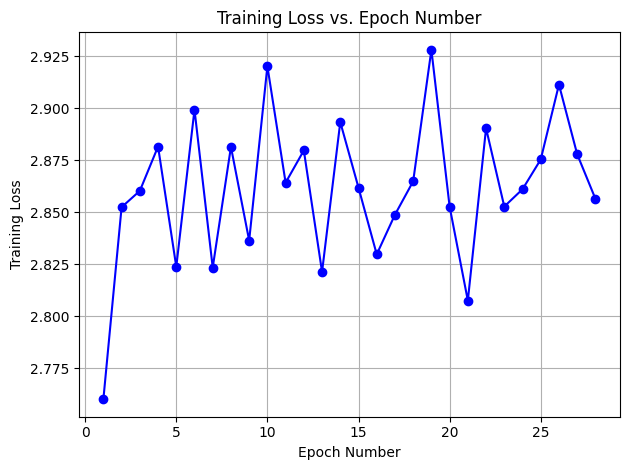

In [27]:
trainLossPerEp = [2.760148777878793, 2.852466075613191, 2.860289515950075, 2.881592264136177, 2.8238090368975133, 2.8993282186765974, 2.823421283021698, 2.881420236788721, 2.8364199014281337, 2.9201851057532213, 2.864240465474156, 2.879726487814791, 2.82135761348647, 2.8933696200527246, 2.8618396391529575, 2.8297829630904943, 2.848827817167166, 2.8648787688583113, 2.928087313259571, 2.8527354950703687, 2.807580807835351, 2.8904028740934, 2.852761992004205, 2.8610736361524762, 2.8753731565668277, 2.9113747166384076,2.8779093053014164, 2.8565063676595317]
plotloss(trainLossPerEp, "Training")

In [28]:
def load_model(model, optim, file_name):
    checkpoint = torch.load(file_name, map_location=torch.device(DEVICE))
    model.load_state_dict(checkpoint["model_state_dict"])
    optim.load_state_dict(checkpoint["optimizer_state_dict"])
    return checkpoint["epoch"]

In [29]:
def getValLoss(train_x, train_y, model, opt, loss_fxn):
    val_loss_lst = []
    for i in range(28):
        fi_name = '/content/drive/MyDrive/model_bert_new_ep_'+str(i)+'.pth'
        load_model(model, opt, fi_name)
        model.eval()
        val_loss, n_val = 0, 0
        with torch.inference_mode():
            for X, y in zip(train_x, train_y):
                y = torch.tensor(y)
                X = tokenizer(X, return_tensors='pt')
                X, y = X.to(DEVICE), y.to(DEVICE)

                logits = model(**X).logits
                val_loss += loss_fxn(logits.squeeze(1)[0], y)
                n_val += 1
        val_loss_lst.append(val_loss/n_val)
        print("Done.")
    return val_loss_lst

In [16]:
val_loss_lst = getValLoss(sentences_val, sim_score_val, model, torch.optim.Adam(model.parameters(), lr=0.001), nn.MSELoss())

KeyboardInterrupt: 

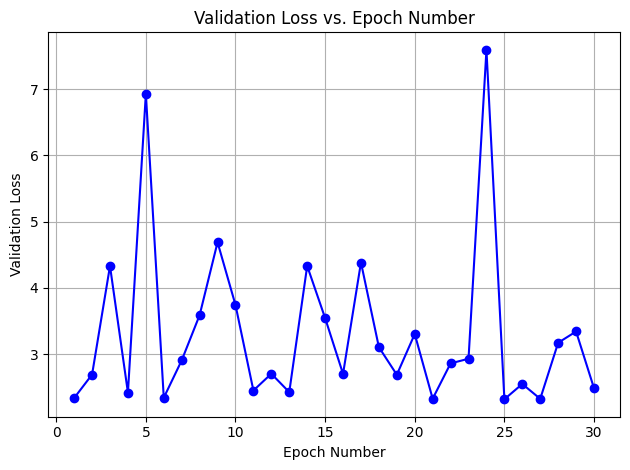

In [ ]:
plotloss(val_loss_lst, "Validation")

In [ ]:
######### DO NOT RUN ###############
model_loc = "/content/drive/MyDrive/Colab_data/NLP_AS3/models/q1/model_bert_new_ep_29.pth"
load_model(model, torch.optim.Adam(model.parameters(), lr=0.001), model_loc)

29

In [ ]:
pred_val = []
model.eval()
with torch.inference_mode():
    for X in sentences_val:
        X = tokenizer(X, return_tensors='pt')
        X = X.to(DEVICE)
        logits = model(**X).logits
        pred_val.append(float(logits))

In [ ]:
PearsonCorrelationCoeff, p_value = pearsonr(pred_val, sim_score_val)

ValueError: x and y must have the same length.